# Reconstruction Sandbox
This notebook is a test-bed for regularization and reconstruction methods

In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

# Load motiondeblur module and Dataset class
import libwallerlab.projects.motiondeblur as md
import libwallerlab.projects.motiondeblur.bluranalysis as analysis
from libwallerlab.utilities.io import Dataset, isDataset

# Platform imports
import os, glob
from os.path import expanduser

# Debugging imports
import llops as yp
import matplotlib.pyplot as plt
import numpy as np

yp.config.setDefaultBackend('arrayfire')
yp.config.setDefaultDatatype('float32')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define Output Path

In [3]:
output_path = os.path.expanduser('~/datasets/motiondeblur/res_target_pulse_count_comparison')
if not os.path.exists(output_path):
    os.mkdir(output_path)

## Get list of datasets

In [4]:
# dataset_parent_dir = '/Users/zfphil/datasets/motiondeblur/02-06-19-MotionDeblur/'
dataset_parent_dir = '/Users/zfphil/Dropbox/02-06-19-MotionDeblur-2'
dataset_dir_list = [x[0] for x in os.walk(dataset_parent_dir)]
_ = dataset_dir_list.pop(0)  # Remove parent dir
dataset_dir_list.sort()
print(len(dataset_dir_list))

70


## Process Datasets

In [5]:
force = False

for dataset_dir in yp.display.progressBar(dataset_dir_list):
    # Create dataset object (loads metadata)
    dataset = Dataset(dataset_dir, use_median_filter=False, subtract_mean_dark_current=False, force_type='motion_deblur')#'res' not in dataset_label)

    # Perform registration
    dataset.motiondeblur.register(force=force)

    # Perform normalization
    dataset.motiondeblur.normalize(force=force)

    # Perform kernel shape 
    dataset.metadata.calibration['blur_vector'] = {'scale': {'axis': 1, 'factor': 1}}

    # dataset.motiondeblur.position_segment_indicies = [4]
    dataset.frame_mask = [4,5,6]

    # Create recon object
    recon = md.recon.Reconstruction(dataset, alpha_blend_distance=1000, pad_mode='mean', estimate_background_poly=True)

    # Perform reconstruction
    recon.reconstruct(iteration_count=100, step_size=1, frame_number=4, mode='global', reg_types={})

    # Save result
    recon.save(output_path, filename=recon.dataset.metadata.file_header, formats=['npz'], save_raw=True, downsample=4)

Loading 1 frames...


KeyboardInterrupt: 

## Perform Analysis on Pre-processed data

In [10]:
# Get list of npz files and parse pulse counts and mean strobe values
npz_list = glob.glob(os.path.join(output_path, '*.npz'))
dataset_dir_list_to_order = [d[:-20] for d in npz_list]
parameter_list = np.asarray([(int(d.split('res_line_')[1].split('_coded')[0]), int(d.split('raster_')[1].split('_motion')[0])) for d in npz_list])
sorted_indicies = np.argsort(1e6 * parameter_list[:, 0] + parameter_list[:,1] ,axis=0)
parameter_list[sorted_indicies, :]
npz_list_sorted = [npz_list[ind] for ind in sorted_indicies]

## Load Template

In [11]:
recovered_template = np.load(npz_list_sorted[60])['object_recovered']

## Just Analyze the 2000 counts data

In [12]:
# Select data
mean_strobed_value = 400
archive_list = [np.load(npz_list[index]) for index in sorted_indicies if parameter_list[index][0] == mean_strobed_value]
pulse_count_list = [parameter_list[index][1] for index in sorted_indicies if parameter_list[index][0] == mean_strobed_value]
recovered_list = [archive['object_recovered'] for archive in archive_list]
raw_list = [archive['y'] for archive in archive_list]

# Register frames
# Crop to center ROI to check alignment
registration_roi = yp.Roi(start=(1052, 3159), shape=(128, 512))
shift_list = [md.recon.registration.registerImage(recovered[registration_roi.slice], recovered_template[registration_roi.slice], axis=1, preprocess_methods='highpass')[0] for recovered in recovered_list]
recovered_list_registered = [yp.circshift(recovered, [-int(s) for s in shift]) for (recovered, shift) in zip(recovered_list, shift_list)]
raw_list_registered = [yp.circshift(raw, [-int(s) for s in shift]) for (raw, shift) in zip(raw_list, shift_list)]

## Determine ROIs

<IPython.core.display.Javascript object>


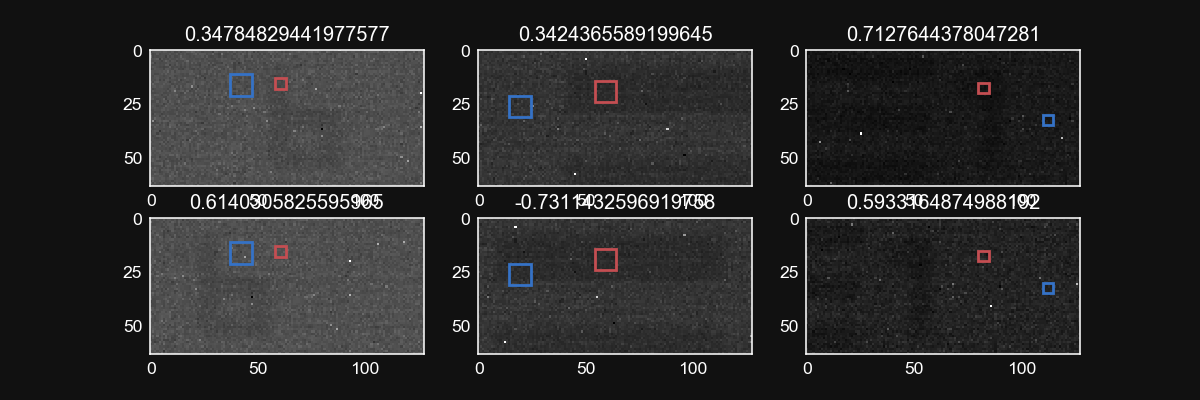

In [18]:
import libwallerlab.utilities.noise as noise
roi_list = (yp.Roi(start=(875, 3150), shape=(64, 128)), 
            yp.Roi(start=(800, 3648), shape=(64, 128)), 
            yp.Roi(start=(1190, 3396), shape=(64, 128)))

snr_list_raw, snr_list_recovered = [], []

index = 0
object_recovered = recovered_list_registered[index]
y = yp.circshift(raw_list_registered[index], (0,45))

signal_roi_list = (yp.Roi(start=(11,37), shape=(10,10)), yp.Roi(start=(21,14), shape=(10,10)), yp.Roi(start=(30,110), shape=(5,5)))
noise_roi_list = (yp.Roi(start=(13,58), shape=(5,5)), yp.Roi(start=(14,54), shape=(10,10)), yp.Roi(start=(15,80), shape=(5,5)))
for index, (roi, signal_roi, noise_roi) in enumerate(zip(roi_list, signal_roi_list, noise_roi_list)):
    
    recovered = yp.dcopy(object_recovered[roi.slice])
    raw = yp.dcopy(y[roi.slice])
    
    # Calculate SNR
    mean_background = 385
    recovered -= mean_background
    raw -= mean_background
#     print(recovered)

    snr_recovered = noise.snr(recovered, signal_roi=signal_roi, noise_roi=noise_roi)
    snr_raw = noise.snr(raw, signal_roi=signal_roi, noise_roi=noise_roi)

    snr_list_raw.append(snr_raw)
    snr_list_recovered.append(snr_recovered)
    
plt.figure()
for index, (roi, signal_roi, noise_roi) in enumerate(zip(roi_list, signal_roi_list, noise_roi_list)):
    plt.subplot(231 + index)
    plt.imshow(object_recovered[roi_list[index].slice])
    signal_roi.draw(plt.gca(), c='b')
    noise_roi.draw(plt.gca(), c='r')
    plt.title(snr_list_recovered[index])
    
    plt.subplot(234 + index)
    plt.imshow(y[roi_list[index].slice])
    signal_roi.draw(plt.gca(), c='b')
    noise_roi.draw(plt.gca(), c='r')
    plt.title(snr_list_raw[index])

## Calculate SNR Values

In [17]:
snr_list_raw, snr_list_recovered = [], []
for recovered, raw, pulse_count in zip(recovered_list_registered, raw_list_registered, pulse_count_list):
    snr_sublist_recovered, snr_sublist_raw = [], []
    for index, (roi, signal_roi, noise_roi) in enumerate(zip(roi_list, signal_roi_list, noise_roi_list)):

        recovered = yp.dcopy(recovered)
        raw = yp.dcopy(raw)
    
        # Calculate SNR
        mean_background = 375
        recovered =  mean_background
        raw -= mean_background
        
        print(yp.mean(recovered))

#         snr_recovered = noise.snr(recovered, signal_roi=signal_roi, noise_roi=noise_roi)
#         snr_raw = noise.snr(raw, signal_roi=signal_roi, noise_roi=noise_roi)

#         snr_sublist_raw.append(snr_raw)
#         snr_sublist_recovered.append(snr_recovered)
        
#     snr_list_raw.append(snr_sublist_raw)
#     snr_list_recovered.append(snr_sublist_recovered)

# plt.figure()
# plt.plot(snr_list_recovered)

392.3778373246597
392.3778373246597
392.3778373246597
427.7436392914654
427.7436392914654
427.7436392914654
463.853387411747
463.853387411747
463.853387411747
553.5037125961496
553.5037125961496
553.5037125961496
642.4461908973096
642.4461908973096
642.4461908973096
721.1582232893157
721.1582232893157
721.1582232893157
793.173376081221
793.173376081221
793.173376081221
1184.4088257051164
1184.4088257051164
1184.4088257051164
1600.2174677830037
1600.2174677830037
1600.2174677830037
1983.3323391549484
1983.3323391549484
1983.3323391549484


## Perform Full Analysis

In [19]:
import libwallerlab.utilities.noise as noise
roi_list = (yp.Roi(start=(875, 3150), shape=(64, 128)), 
            yp.Roi(start=(800, 3648), shape=(64, 128)), 
            yp.Roi(start=(1190, 3396), shape=(64, 128)))

snr_list_raw, snr_list_recovered = [], []

index = 3
object_recovered = recovered_list_registered[index]
y = yp.circshift(raw_list_registered[index], (0,45))

signal_roi_list = (yp.Roi(start=(11,37), shape=(10,10)), yp.Roi(start=(21,14), shape=(10,10)), yp.Roi(start=(30,110), shape=(5,5)))
noise_roi_list = (yp.Roi(start=(13,58), shape=(5,5)), yp.Roi(start=(14,54), shape=(10,10)), yp.Roi(start=(15,80), shape=(5,5)))

snr_list_recovered_full, snr_list_raw_full = [], []
# Loop over strobe mean values
strobe_mean_list = [400, 450, 500, 700, 1000, 1500, 2000]
for mean_strobed_value in yp.display.progressBar(strobe_mean_list):
    
    # Select data
    archive_list = [np.load(npz_list[index]) for index in sorted_indicies if parameter_list[index][0] == mean_strobed_value]
    pulse_count_list = [parameter_list[index][1] for index in sorted_indicies if parameter_list[index][0] == mean_strobed_value]
    recovered_list = [archive['object_recovered'] for archive in archive_list]
    raw_list = [archive['y'] for archive in archive_list]

    # Register frames
    registration_roi = yp.Roi(start=(1052, 3159), shape=(128, 512))
    shift_list = [md.recon.registration.registerImage(recovered[registration_roi.slice], recovered_template[registration_roi.slice], axis=1, preprocess_methods='highpass')[0] for recovered in recovered_list]
    recovered_list_registered = [yp.circshift(recovered, [-int(s) for s in shift]) for (recovered, shift) in zip(recovered_list, shift_list)]
    raw_list_registered = [yp.circshift(raw, [-int(s) for s in shift]) for (raw, shift) in zip(raw_list, shift_list)]
    
    snr_list_raw, snr_list_recovered = [], []
    for recovered_registered, raw_registered, pulse_count in zip(recovered_list_registered, raw_list_registered, pulse_count_list):
        snr_sublist_recovered, snr_sublist_raw = [], []
        for index, (roi, signal_roi, noise_roi) in enumerate(zip(roi_list, signal_roi_list, noise_roi_list)):

            recovered = yp.dcopy(recovered_registered)
            raw = yp.dcopy(raw_registered)

            # Calculate SNR
            mean_background = 385
            recovered -= mean_background
            raw -= mean_background

            snr_recovered = noise.snr(recovered, signal_roi=signal_roi, noise_roi=noise_roi)
            snr_raw = noise.snr(raw, signal_roi=signal_roi, noise_roi=noise_roi)

            snr_sublist_raw.append(snr_raw)
            snr_sublist_recovered.append(snr_recovered)

        snr_list_raw.append(snr_sublist_raw)
        snr_list_recovered.append(snr_sublist_recovered)
        
    snr_list_raw_full.append(snr_list_raw)
    snr_list_recovered_full.append(snr_list_recovered)


<IPython.core.display.Javascript object>


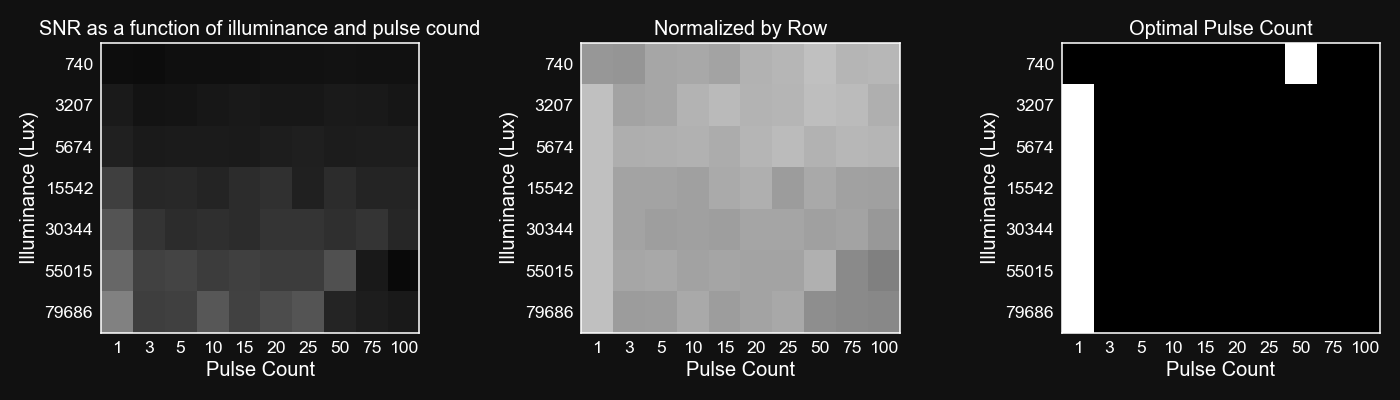

In [20]:
plt.figure(figsize=(14,4))
q = np.asarray(snr_list_recovered_full)
q = np.sum(q, axis=2) / 3

# Kill one weird datapoint
q[5,9] = 0

total_throughput = 50e-6

counts_list = [400, 450, 500, 700, 1000, 1500, 2000]
illuminance_list = [int(analysis.countsToIlluminance(counts, total_throughput)) for counts in counts_list]

plt.subplot(131)
plt.imshow((q))
plt.clim((-2, 50))
plt.xticks(ticks=np.arange(10), labels=[1,3,5,10,15,20,25,50,75,100])
plt.yticks(ticks=np.arange(7), labels=illuminance_list)
plt.xlabel('Pulse Count')
plt.ylabel('Illuminance (Lux)')
plt.axis('tight')
plt.title('SNR as a function of illuminance and pulse cound')

plt.subplot(132)
plt.imshow(q / yp.max(q, axis=1)[:, np.newaxis])
plt.clim((-2, 2))
plt.xticks(ticks=np.arange(10), labels=[1,3,5,10,15,20,25,50,75,100])
plt.yticks(ticks=np.arange(7), labels=illuminance_list)
plt.xlabel('Pulse Count')
plt.ylabel('Illuminance (Lux)')
plt.axis('tight')
plt.title('Normalized by Row')

plt.subplot(133)
plt.imshow(q / yp.max(q, axis=1)[:, np.newaxis] == 1)
plt.xticks(ticks=np.arange(10), labels=[1,3,5,10,15,20,25,50,75,100])
plt.yticks(ticks=np.arange(7), labels=illuminance_list)
plt.xlabel('Pulse Count')
plt.ylabel('Illuminance (Lux)')
plt.axis('tight')
plt.title('Optimal Pulse Count')

plt.tight_layout()

In [21]:
np.savez('../notebooks_publications/pulse_snr_results.npz', data=q, pulse_count_list=pulse_count_list, illuminance_list=illuminance_list)

## Export ROIs for Figure

In [355]:
# Select data
mean_strobed_value = 2000
archive_list = [np.load(npz_list[index]) for index in sorted_indicies if parameter_list[index][0] == mean_strobed_value]
pulse_count_list = [parameter_list[index][1] for index in sorted_indicies if parameter_list[index][0] == mean_strobed_value]
recovered_list = [archive['object_recovered'] for archive in archive_list]
raw_list = [archive['y'] for archive in archive_list]

# Register frames
# Crop to center ROI to check alignment
registration_roi = yp.Roi(start=(1052, 3159), shape=(128, 512))
shift_list = [md.recon.registration.registerImage(recovered[registration_roi.slice], recovered_template[registration_roi.slice], axis=1, preprocess_methods='highpass')[0] for recovered in recovered_list]
recovered_list_registered = [yp.circshift(recovered, [-int(s) for s in shift]) for (recovered, shift) in zip(recovered_list, shift_list)]
raw_list_registered = [yp.circshift(raw, [-int(s) for s in shift]) for (raw, shift) in zip(raw_list, shift_list)]

Using TensorFlow backend.


<IPython.core.display.Javascript object>


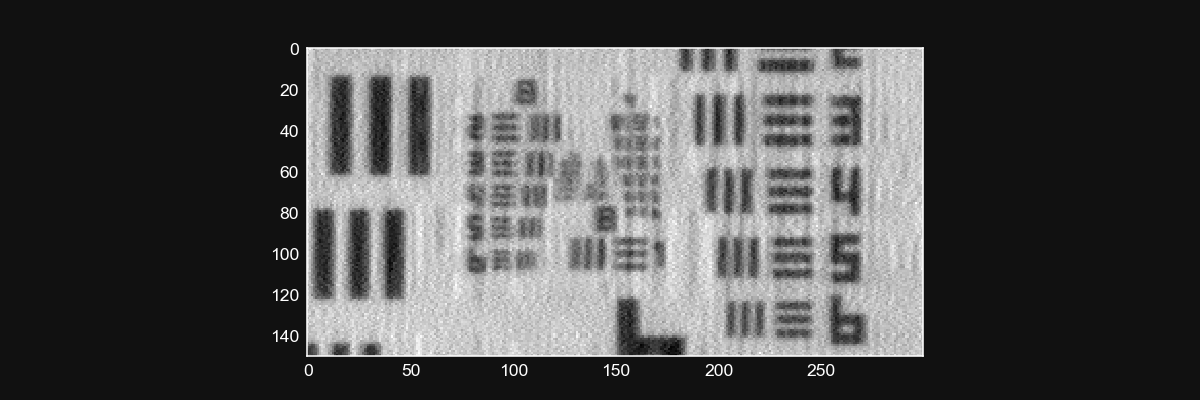

In [372]:
roi = yp.Roi(start=(1010,3210), shape=(150,300))
plt.figure()
plt.imshow(recovered_list_registered[1][roi.slice])

<IPython.core.display.Javascript object>


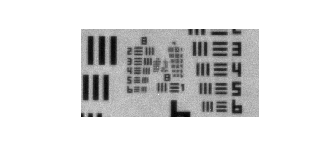

<IPython.core.display.Javascript object>


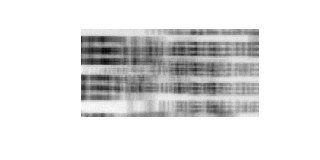

<IPython.core.display.Javascript object>


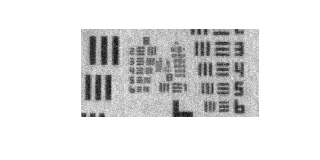

In [393]:
plt.style.use('deblur')
figure_directory = '/Users/zfphil/Dropbox/Berkeley/Phase-Deblurring/journalpaper/figures'

roi = yp.Roi(start=(1010,3210), shape=(150,300))

offset = -75
recovered_strobe = recovered_list[0][roi.slice]
recovered_coded = yp.circshift(recovered_list[6], (0, offset))[roi.slice]
raw_coded = yp.circshift(raw_list[6], (0, 50))[roi.slice]

plt.figure(figsize=(4,2))
plt.imshow(recovered_strobe)
plt.axis('off')
# plt.clim((0.8,1.1))
plt.tight_layout()
plt.savefig(os.path.join(figure_directory, 'snr_res_strobe.pdf'), transparent=True)

plt.figure(figsize=(4,2))
plt.imshow(raw_coded)
plt.axis('off') 
plt.tight_layout()
plt.savefig(os.path.join(figure_directory, 'snr_res_blurred.pdf'), transparent=True)

plt.figure(figsize=(4,2))
plt.imshow(recovered_coded)

plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(figure_directory, 'snr_res_deblurred.pdf'), transparent=True)

[[1662.3265 1710.8508 1629.1755 ... 1671.1653 1698.2346 1651.6973]
 [1695.4001 1649.6732 1743.8643 ... 1608.2463 1711.8301 1622.6786]
 [1795.5227 1736.189  1736.1287 ... 1639.2748 1660.535  1720.5334]
 ...
 [1589.9666 1705.6807 1662.8168 ... 1677.5957 1722.1526 1681.3757]
 [1755.4082 1714.4868 1687.1873 ... 1775.5886 1685.354  1749.3035]
 [1786.5925 1617.2451 1691.1272 ... 1739.758  1745.5261 1680.5029]]
[[1734.5823  1660.5421  1579.777   ... 1753.3728  1611.2491  1423.9994 ]
 [1705.7649  1603.8485  1618.2455  ... 1588.2362  1569.9797  1595.8925 ]
 [1576.0127  1629.8221  1665.3672  ... 1598.8177  1515.2666  1551.742  ]
 ...
 [1497.6447  1627.4939  1508.1854  ...  221.35272  207.89606  160.80695]
 [1539.0415  1642.9176  1608.264   ...  163.7055   175.23285  185.79962]
 [1650.6685  1636.2157  1566.9282  ...  169.47949  173.32031  205.9892 ]]
[[1673.3425  1526.9072  1560.051   ... 1813.8474  1726.1726  1776.7754 ]
 [1558.271   1511.384   1447.9065  ... 1728.2554  1692.19    1692.1582 ]
 [

<IPython.core.display.Javascript object>


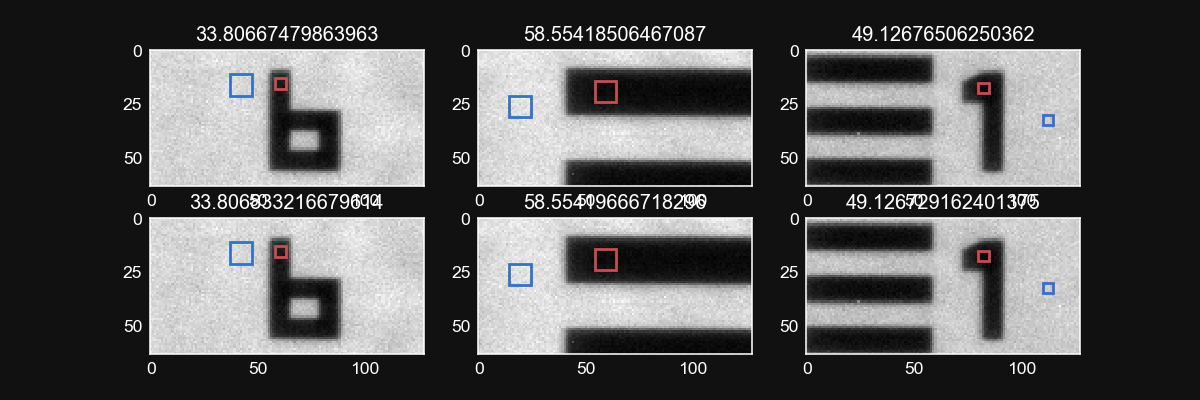

In [356]:
import libwallerlab.utilities.noise as noise
roi_list = (yp.Roi(start=(875, 3150), shape=(64, 128)), 
            yp.Roi(start=(800, 3648), shape=(64, 128)), 
            yp.Roi(start=(1190, 3396), shape=(64, 128)))

snr_list_raw, snr_list_recovered = [], []

index = 0
object_recovered = recovered_list_registered[index]
y = yp.circshift(raw_list_registered[index], (0,45))

signal_roi_list = (yp.Roi(start=(11,37), shape=(10,10)), yp.Roi(start=(21,14), shape=(10,10)), yp.Roi(start=(30,110), shape=(5,5)))
noise_roi_list = (yp.Roi(start=(13,58), shape=(5,5)), yp.Roi(start=(14,54), shape=(10,10)), yp.Roi(start=(15,80), shape=(5,5)))
for index, (roi, signal_roi, noise_roi) in enumerate(zip(roi_list, signal_roi_list, noise_roi_list)):
    
    recovered = yp.dcopy(object_recovered[roi.slice])
    raw = yp.dcopy(y[roi.slice])
    
    # Calculate SNR
    mean_background = 385
    recovered -= mean_background
    raw -= mean_background
    print(recovered)

    snr_recovered = noise.snr(recovered, signal_roi=signal_roi, noise_roi=noise_roi)
    snr_raw = noise.snr(raw, signal_roi=signal_roi, noise_roi=noise_roi)

    snr_list_raw.append(snr_raw)
    snr_list_recovered.append(snr_recovered)
    
plt.figure()
for index, (roi, signal_roi, noise_roi) in enumerate(zip(roi_list, signal_roi_list, noise_roi_list)):
    plt.subplot(231 + index)
    plt.imshow(object_recovered[roi_list[index].slice])
    signal_roi.draw(plt.gca(), c='b')
    noise_roi.draw(plt.gca(), c='r')
    plt.title(snr_list_recovered[index])
    
    plt.subplot(234 + index)
    plt.imshow(y[roi_list[index].slice])
    signal_roi.draw(plt.gca(), c='b')
    noise_roi.draw(plt.gca(), c='r')
    plt.title(snr_list_raw[index])